In [ ]:
import os
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers,models
import random


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Data_dir = "/content/drive/MyDrive/Datasets/vox_indian"
input_shape= (128,128)
embedding_size = 256
num_samples=500

In [ ]:
def load_speaker_map(data_dir):
    speaker_map = {}
    for speaker in os.listdir(data_dir):
        speaker_path = os.path.join(data_dir, speaker)
        if os.path.isdir(speaker_path):
            files = []
            for root, _, filenames in os.walk(speaker_path):
                files.extend([os.path.join(root, f) for f in filenames])
            speaker_map[speaker] = files
    return speaker_map

Data_dir = "/content/drive/MyDrive/Datasets/vox_indian"
speaker_map = load_speaker_map(Data_dir)

In [ ]:
def pre_process(file_path, target_shape=(128, 128), sr=16000):
    """Returns mel-spectrogram with shape (128, 128, 1)"""
    y, _ = librosa.load(file_path, sr=sr)
    y = librosa.util.fix_length(y, size=3*sr)  # 3 seconds x 16k samplerate=48k
    mel = librosa.feature.melspectrogram(y=y, sr=sr,
                                       n_mels=target_shape[0],
                                       hop_length=512)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)
    mel_db = tf.image.resize(mel_db[..., tf.newaxis], target_shape)

    return mel_db.numpy()

print("\nTesting audio processing...")
sample_file = list(load_speaker_map(Data_dir).values())[0][0]  # Get first file
sample_mel = pre_process(sample_file)
print(f"DEMO OUTPUT: Processed spectrogram shape: {sample_mel.shape}")
print(f"Sample values:\n{sample_mel[0, :5, 0]}")


Testing audio processing...
DEMO OUTPUT: Processed spectrogram shape: (128, 128, 1)
Sample values:
[0.60858566 0.5791833  0.53700113 0.48924765 0.45931637]


In [ ]:
from scipy.spatial.distance import cosine
import numpy as np
from tqdm import tqdm

def generate_triplets(speakers, model, num_samples=100):

    triplet_paths = []
    spk_list = list(speakers.keys())

    with tqdm(total=num_samples, desc="Creating triplets with hard negatives") as pbar:
        for _ in range(num_samples):
            anchor_spk = random.choice(spk_list)
            while len(speakers[anchor_spk]) < 2:
                anchor_spk = random.choice(spk_list)

            # Select anchor and positive from the same speaker
            anchor, positive = random.sample(speakers[anchor_spk], 2)
            processed_anchor = pre_process(anchor)
            print("Processed shape:", processed_anchor.shape)  # Debugging

            anchor_embedding = model.predict(np.expand_dims(processed_anchor, axis=0))
            # Find the hardest negative (most similar to anchor)
            hardest_neg = None
            max_similarity = -1

            for neg_spk in spk_list:
                if neg_spk == anchor_spk:
                    continue
                for neg_sample in speakers[neg_spk]:
                    neg_embedding = model.predict(np.expand_dims(pre_process(neg_sample), axis=0))
                    similarity = 1 - cosine(anchor_embedding.flatten(), neg_embedding.flatten())  # Cosine similarity

                    if similarity > max_similarity:
                        max_similarity = similarity
                        hardest_neg = neg_sample

            triplet_paths.append((anchor, positive, hardest_neg))
            pbar.update(1)

    print("\nDEMO OUTPUT: First 3 triplets:")
    for t in triplet_paths[:3]:
        print(f"A: {os.path.basename(t[0])} | P: {os.path.basename(t[1])} | N: {os.path.basename(t[2])}")

    return triplet_paths


In [ ]:
def create_encoder():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 1)),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256)
    ])

class SiameseModel(tf.keras.Model):
    def __init__(self):
        super(SiameseModel, self).__init__()
        self.encoder = create_encoder()

    def call(self, inputs):
        anc = self.encoder(inputs[0])
        pos = self.encoder(inputs[1])
        neg = self.encoder(inputs[2])

        # Stack embeddings along new dimension (batch_size, 3, 512)
        return tf.stack([anc, pos, neg], axis=1)

encoder_model= create_encoder()
sample_input = np.random.rand(1,128,128, 1)
sample_output = encoder_model(sample_input)
print(f"DEMO OUTPUT: Input shape: {sample_input.shape}")
print(f"Model output shape: {sample_output.shape}")

DEMO OUTPUT: Input shape: (1, 128, 128, 1)
Model output shape: (1, 256)


In [ ]:
class TripletLoss(tf.keras.losses.Loss):
    def __init__(self, margin=0.25):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        # Unpack from stacked tensor
        anchor = y_pred[:, 0, :]  # (batch_size, 256)
        positive = y_pred[:, 1, :]
        negative = y_pred[:, 2, :]

        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        loss = tf.maximum(pos_dist - neg_dist + self.margin, 0.0)
        return tf.reduce_mean(loss)


In [ ]:
def train_model():
    anchors, positives, negatives = [], [], []

    with tqdm(total=len(triplets), desc="Preprocessing") as pbar:
        for a, p, n in triplets:
            anchors.append(pre_process(a))
            positives.append(pre_process(p))
            negatives.append(pre_process(n))
            pbar.update(1)

    anchors = np.array(anchors)
    positives = np.array(positives)
    negatives = np.array(negatives)

    model = SiameseModel()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=TripletLoss())

    # Train with proper input format
    model.fit(
        x=[anchors, positives, negatives],
        y=np.zeros((len(triplets),)),  # Dummy labels
        batch_size=32,
        epochs=10
    )
    return model

# Train the model


In [ ]:
def evaluate(model, test_spk, trials=50):
    enrollments = {}
    for speaker in test_spk:
        if speaker in speaker_map:
            enroll_file = random.choice(speaker_map[speaker])
            enrollments[speaker] = pre_process(enroll_file)
        else:
            print(f"Warning: Speaker {speaker} not found in speaker_map, skipping...")
            continue  # Skip to the next speaker

    accurate = 0
    for _ in range(trials):  # Use the trials argument for iterations
        if random.random() < 0.5:
            spk = random.choice(test_spk)
            test_file = random.choice(speaker_map[spk])
            enrollment = enrollments[spk]
            true_label = 1
        else:
            spk1, spk2 = random.sample(test_spk, 2)
            test_file = random.choice(speaker_map[spk1])
            enrollment = enrollments[spk2]
            true_label = 0

        test_data = pre_process(test_file)

        emb1 = model.encoder(enrollment[np.newaxis, :, :, np.newaxis])
        emb2 = model.encoder(test_data[np.newaxis, :, :, np.newaxis])

        emb1 = emb1.numpy()
        emb2 = emb2.numpy()

        # cosine similarity
        similarity = np.dot(emb1, emb2.T) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

        if similarity > 0.5:
            pred = 1
        else:
            pred = 0

        if pred == true_label:
            accurate += 1

    accuracy = accurate / trials
    return accuracy

In [ ]:
if __name__ == "__main__":
    all_spk = list(load_speaker_map(Data_dir).keys())
    train_spk = random.sample(all_spk, int(0.8*len(all_spk)))
    test_spk = [spk for spk in all_spk if spk not in train_spk]
    print(f"Total speakers in dataset: {len(speaker_map)}")
    print(f"Speakers in test set: {len(test_spk)}")
    print(f"Example test speakers: {test_spk[:5]}")

    model= train_model()
    triplets = generate_triplets(load_speaker_map(Data_dir),model, num_samples)
    accuracy = evaluate(model, test_spk,trials =50)
    print(f"One shot verification accuracy: {accuracy}")

Total speakers in dataset: 22
Speakers in test set: 5
Example test speakers: ['id10724', 'id10393', 'id11089', 'id10943', 'id10956']


Preprocessing: 100%|██████████| 500/500 [00:31<00:00, 15.82it/s]


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.2501
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - loss: 0.2482
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - loss: 0.2458
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - loss: 0.2407
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - loss: 0.2417
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - loss: 0.2387
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - loss: 0.2374
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - loss: 0.2226
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - loss: 0.2200
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - loss: 0.2069


Creating triplets with hard negatives:   0%|          | 0/500 [00:00<?, ?it/s]

Processed shape: (128, 128, 1)


ValueError: Exception encountered when calling Conv2D.call().

[1mNegative dimension size caused by subtracting 3 from 1 for '{{node siamese_model_11_1/sequential_15_1/conv2d_30_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](siamese_model_11_1/sequential_15_1/ExpandDims, siamese_model_11_1/sequential_15_1/conv2d_30_1/convolution/ReadVariableOp)' with input shapes: [128,128,1,1], [3,3,1,64].[0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(128, 128, 1, 1), dtype=float32)

0.42 accuracy without hard triplet mining


In [ ]:
accuracy = evaluate(model, test_spk, trials =50)
print(f"One shot verification accuracy: {accuracy}")

One shot verification accuracy: 0.6


TypeError: 'History' object is not subscriptable

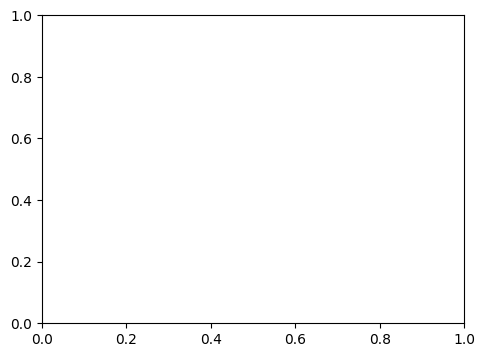

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model.history['loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [ ]:
def test_custom_files(model, anchor_path, positive_path, negative_path, threshold=0.5):
    """
    Test custom audio files
    Example usage:
    test_custom_files(model,
                    "path/to/anchor.wav",
                    "path/to/positive.wav",
                    "path/to/negative.wav")
    """
    def process_and_embed(path):
        spec = pre_process(path)
        return model.encoder(np.expand_dims(spec, 0))

    # Get embeddings
    anchor_emb = process_and_embed(anchor_path)
    positive_emb = process_and_embed(positive_path)
    negative_emb = process_and_embed(negative_path)

    # Calculate similarities
    pos_sim = tf.reduce_sum(anchor_emb * positive_emb) / (
        tf.norm(anchor_emb) * tf.norm(positive_emb)
    )
    neg_sim = tf.reduce_sum(anchor_emb * negative_emb) / (
        tf.norm(anchor_emb) * tf.norm(negative_emb)
    )

    print(f"\nPositive Similarity: {pos_sim.numpy()[0]:.2%}")
    print(f"Negative Similarity: {neg_sim.numpy()[0]:.2%}")
    print(f"Verification Result: {'Accepted' if pos_sim > threshold else 'Rejected'}")
    print(f"Imposter Result: {'Rejected' if neg_sim < threshold else 'Accepted'}")
